## Interactive Demo 3: Analyzing semi-structured data using the SUPER data type
In this demo, you use Amazon Redshift to analyze years worth of movie data. The movie data is semi-structured, which doesn't conform to the rigid and tabular structure of the relational data model used in SQL databases. The data contains tags that reference distinct entities within it. The entities can contain complex values, such as arrays, nested structures, and other complex structures associated with serialization formats such as JSON. The SUPER data type is a set of schemaless array and structure values that encompass all other scalar types of Amazon Redshift. With the Redshift SUPER data type, you can load JSON data to the Redshift cluster in a few simple steps, and then start analyzing the data.

The complete set of movie data is loaded to an Amazon Simple Storage Service (Amazon S3) data bucket. Here is a sample in JSON structure. 
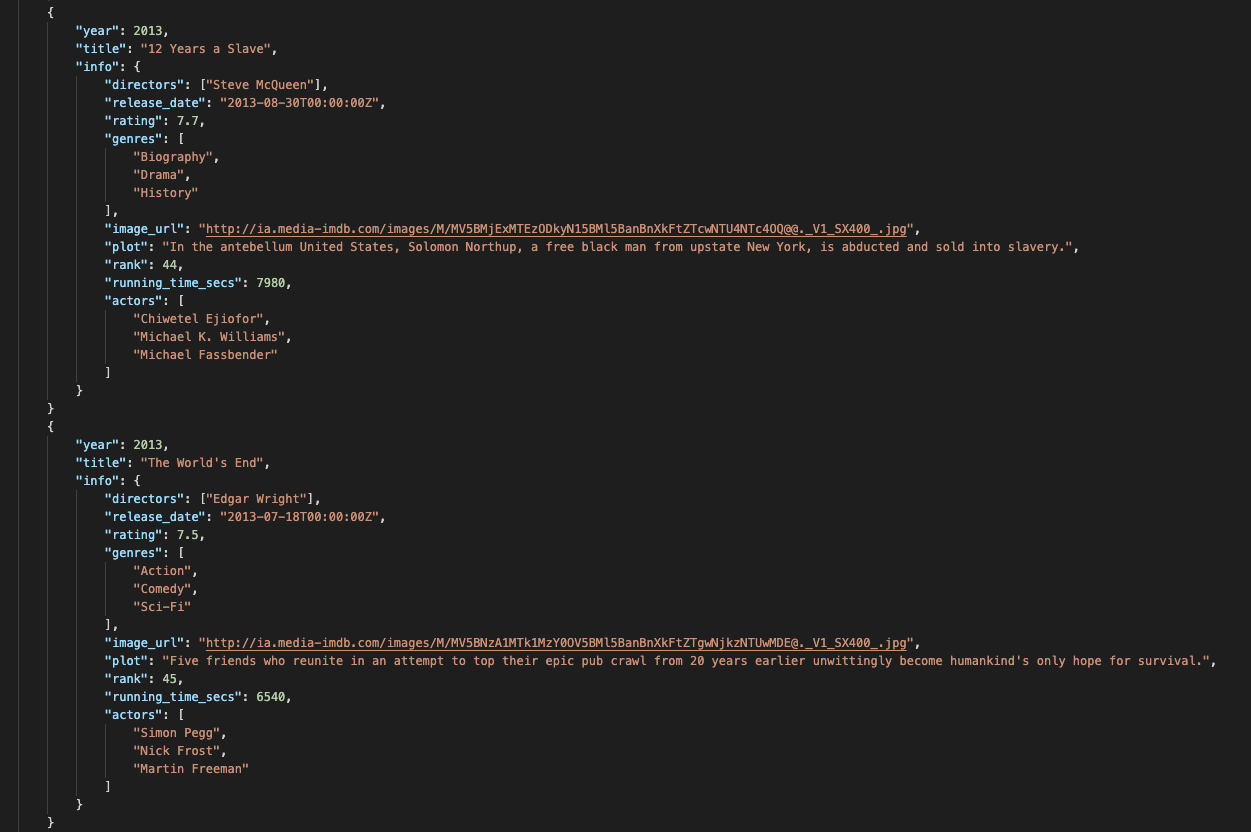

## Prerequisites
This demo requires the following Python modules and custom waiter for the Amazon Redshift Data API to wait for the completed run of the current SQL statement.

In [1]:
# These are libraries required for the demo activities.

import botocore.session as s
from botocore.exceptions import ClientError
import boto3.session
import json
import boto3
import sagemaker
import operator
from botocore.exceptions import WaiterError
from botocore.waiter import WaiterModel
from botocore.waiter import create_waiter_with_client

import pandas as pd
import numpy as np

# Create a custom waiter for the Amazon Redshift Data API to wait for the completed run of the current SQL statement.
waiter_name = 'DataAPIExecution'

delay=2
max_attempts=3

# Configure the waiter settings.
waiter_config = {
  'version': 2,
  'waiters': {
    'DataAPIExecution': {
      'operation': 'DescribeStatement',
      'delay': delay,
      'maxAttempts': max_attempts,
      'acceptors': [
        {
          "matcher": "path",
          "expected": "FINISHED",
          "argument": "Status",
          "state": "success"
        },
        {
          "matcher": "pathAny",
          "expected": ["PICKED","STARTED","SUBMITTED"],
          "argument": "Status",
          "state": "retry"
        },
        {
          "matcher": "pathAny",
          "expected": ["FAILED","ABORTED"],
          "argument": "Status",
          "state": "failure"
        }
      ],
    },
  },
}

## Retrieve DB detail secrets from AWS Secrets Manager and establish a connection with the Amazon Redshift cluster
You must retrieve the following from AWS Secrets Manager:
* Cluster identifier
* Secrets ARN
* Database name
* Data bucket

In [2]:
secret_name='demolab-secrets' # Replace the secret name with yours.
session = boto3.session.Session()
region = session.region_name

client = session.client(
        service_name='secretsmanager',
        region_name=region
    )

try:
    get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    secret_arn=get_secret_value_response['ARN']

except ClientError as e:
    print("Error retrieving secret. Error: " + e.response['Error']['Message'])
    
else:
    # Depending on whether the secret is a string or binary, one of these fields will be populated.
    if 'SecretString' in get_secret_value_response:
        secret = get_secret_value_response['SecretString']
    else:
        secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            
secret_json = json.loads(secret)

redshift_iam_role = sagemaker.get_execution_role() 
print("IAM Role: " + redshift_iam_role)

cluster_id = secret_json['dbClusterIdentifier']
db = secret_json['db']
s3_data_path = "s3://{}/data/stock_prices.csv".format(secret_json['dataBucket'])
print("Region: " + region + "\nCluster_id: " + cluster_id + "\nDB: " + db + "\nSecret ARN: " + secret_arn + "\ndata file location: " + s3_data_path)

# Set up the Data API client.
client_redshift = session.client("redshift-data")
print("Data API client successfully loaded")

# List all the schemas in the current database `demolab`.
client_redshift.list_schemas(
    Database= db, 
    SecretArn= secret_arn, 
    ClusterIdentifier= cluster_id)["Schemas"]

IAM Role: arn:aws:iam::407428058648:role/LabStack-dced81f9-5cb5-497f-RedshiftSagemakerRole-1H5VSC3RWMTVU
Region: us-west-2
Cluster_id: redshiftcluster-flgrycovpj41
DB: demolab
Secret ARN: arn:aws:secretsmanager:us-west-2:407428058648:secret:demolab-secrets-peg68R
data file location: s3://labstack-dced81f9-5cb5-497f-bdf0-4818a-databucket-14d17fgewsvsq/data/stock_prices.csv
Data API client successfully loaded


['catalog_history',
 'information_schema',
 'pg_automv',
 'pg_catalog',
 'pg_internal',
 'public',
 'stocksummary']

## Create a movie table with the SUPER data type

In [3]:
# First, set the waiter when running a query to help you wait for the response.
waiter_model = WaiterModel(waiter_config)
custom_waiter = create_waiter_with_client(waiter_name, waiter_model, client_redshift)

# Create movie table with schema.
query_str = "CREATE TABLE movies (b super);"

res = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_str, ClusterIdentifier= cluster_id)
id=res["Id"]

try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API.")
except WaiterError as e:
    print (e)
    
desc=client_redshift.describe_statement(Id=id)
print("Status: " + desc["Status"] + ". Run time: %d milliseconds" %float(desc["Duration"]/pow(10,6)))

Done waiting to finish Data API.
Status: FINISHED. Run time: 51 milliseconds


## Loading data
Now, you load data from Amazon S3 to the SUPER table.

In [4]:
# Load the data from S3 bucket.
movies_data_path = "s3://{}/data/moviedata.json".format(secret_json['dataBucket'])
query = "COPY movies FROM '" + movies_data_path + "' IAM_ROLE '" + redshift_iam_role + "' FORMAT JSON 'noshred';"

print("COPY query: " + query)


# Run COPY statements in parallel.
resp = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query, ClusterIdentifier= cluster_id)

print("Redshift COPY started ...")

id = resp["Id"]
print("\nID: " + id)

# Waiter in try block and wait for DATA API to return.
try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API for the COPY statement.")
except WaiterError as e:
    print (e)

desc=client_redshift.describe_statement(Id=id)
print("[COPY] Status: " + desc["Status"] + ". Run time: %d milliseconds" %float(desc["Duration"]/pow(10,6)))

COPY query: COPY movies FROM 's3://labstack-dced81f9-5cb5-497f-bdf0-4818a-databucket-14d17fgewsvsq/data/moviedata.json' IAM_ROLE 'arn:aws:iam::407428058648:role/LabStack-dced81f9-5cb5-497f-RedshiftSagemakerRole-1H5VSC3RWMTVU' FORMAT JSON 'noshred';
Redshift COPY started ...

ID: 6138d138-38a3-4014-aae5-3ff2a4e19c54
Done waiting to finish Data API for the COPY statement.
[COPY] Status: FINISHED. Run time: 1757 milliseconds


## Querying data (in-place analytics)

You can use Amazon Redshift Data API to perform in-place data analytics.

In [5]:
# Find movie info for 2008.

query_str = "select b.year, b.title, b.info.directors[0], b.info.actors[0], b.info.rating, b.info.release_date \
             from movies \
             where b.year = 2008;"


res = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_str, ClusterIdentifier= cluster_id)
print("Redshift Data API execution  started ...")
id = res["Id"]

# Waiter in try block and wait for DATA API to return.
try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API.")
except WaiterError as e:
    print (e)

desc=client_redshift.describe_statement(Id=id)
print("[COPY] Status: " + desc["Status"] + ". Run time: %d milliseconds" %float(desc["Duration"]/pow(10,6)))

output=client_redshift.get_statement_result(Id=id)
nrows=output["TotalNumRows"]
ncols=len(output["ColumnMetadata"])
resultrows=output["Records"]

col_labels=[]
for i in range(ncols): col_labels.append(output["ColumnMetadata"][i]['label'])
                                              

# Load the results into a dataframe.
df = pd.DataFrame(np.array(resultrows), columns=col_labels)

# Reformatting the results before display.
for i in range(ncols): 
    df[col_labels[i]]=df[col_labels[i]].apply(operator.itemgetter('stringValue'))

df


Redshift Data API execution  started ...
Done waiting to finish Data API.
[COPY] Status: FINISHED. Run time: 150 milliseconds


,year,title,directors,actors,rating,release_date
0,2008,"""The Dark Knight""","""Christopher Nolan""","""Christian Bale""",9,"""2008-07-14T00:00:00Z"""
1,2008,"""Iron Man""","""Jon Favreau""","""Robert Downey Jr.""",7.9,"""2008-04-14T00:00:00Z"""
2,2008,"""Twilight""","""Catherine Hardwicke""","""Kristen Stewart""",5.2,"""2008-11-17T00:00:00Z"""
3,2008,"""Pineapple Express""","""David Gordon Green""","""Seth Rogen""",6.9,"""2008-08-06T00:00:00Z"""
4,2008,"""Taken""","""Pierre Morel""","""Liam Neeson""",7.8,"""2008-02-27T00:00:00Z"""
...,...,...,...,...,...,...
197,2008,"""Me and Orson Welles""","""Richard Linklater""","""Zac Efron""",6.7,"""2008-09-05T00:00:00Z"""
198,2008,"""Management""","""Stephen Belber""","""Jennifer Aniston""",5.9,"""2008-09-07T00:00:00Z"""
199,2008,"""The Yellow Handkerchief""","""Udayan Prasad""","""William Hurt""",6.7,"""2008-01-18T00:00:00Z"""
200,2008,"""American Violet""","""Tim Disney""","""Nicole Beharie""",6.7,"""2008-08-29T00:00:00Z"""


## Create, load, and query table with SUPER data type with known JSON structure

In this activity, you create a SUPER table with an auto feature where you know the structure of the JSON with nested data elements. In the movie dataset, **year** and **title** are simple varchar fields, whereas the **info** element is nested. Next, create a new table with this known JSON information.

In [6]:
# Create movies_auto table where you know the JSON structure.
query_str = "create table movies_auto (year varchar, title varchar, info super);"

res = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_str, ClusterIdentifier= cluster_id)
id=res["Id"]

try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API.")
except WaiterError as e:
    print (e)
    
desc=client_redshift.describe_statement(Id=id)
print("Status: " + desc["Status"] + ". Run time: %d milliseconds" %float(desc["Duration"]/pow(10,6)))

# Load the data from S3 bucket.

movies_data_path = "s3://{}/data/moviedata.json".format(secret_json['dataBucket'])
query = "COPY movies_auto FROM '" + movies_data_path + "' IAM_ROLE '" + redshift_iam_role + "' FORMAT JSON 'auto';"

# Run COPY statements in parallel.
resp = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query, ClusterIdentifier= cluster_id)

print("Redshift COPY started ...")

id = resp["Id"]
print("\nID: " + id)

# Waiter in try block and wait for DATA API to return.
try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API for the COPY statement.")
except WaiterError as e:
    print (e)
    

desc=client_redshift.describe_statement(Id=id)
print("[COPY] Status: " + desc["Status"] + ". Run time: %d milliseconds" %float(desc["Duration"]/pow(10,6)))



Done waiting to finish Data API.
Status: FINISHED. Run time: 48 milliseconds
Redshift COPY started ...

ID: 7413c8f0-1506-4ad6-95ac-063f8c374f4d
Done waiting to finish Data API for the COPY statement.
[COPY] Status: FINISHED. Run time: 1496 milliseconds


In [7]:
# Find 2008 movie info from movie_auto table. 
query_str = "select year, title, info.rating, info.actors[0], info.directors[0], info.genres[0] \
            from movies_auto \
            where year = 2008;"

res = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_str, ClusterIdentifier= cluster_id)
print("Redshift Data API execution  started ...")
id = res["Id"]

# Waiter in try block and wait for DATA API to return.
try:
    custom_waiter.wait(Id=id)
    print("Done waiting to finish Data API.")
except WaiterError as e:
    print (e)

desc=client_redshift.describe_statement(Id=id)
print("[COPY] Status: " + desc["Status"] + ". Run time: %d milliseconds" %float(desc["Duration"]/pow(10,6)))

output=client_redshift.get_statement_result(Id=id)
nrows=output["TotalNumRows"]
ncols=len(output["ColumnMetadata"])
resultrows=output["Records"]

col_labels=[]
for i in range(ncols): col_labels.append(output["ColumnMetadata"][i]['label'])
                                              
# Load the results into a dataframe.
df = pd.DataFrame(np.array(resultrows), columns=col_labels)

# Reformatting the results before display.
for i in range(ncols): 
    df[col_labels[i]]=df[col_labels[i]].apply(operator.itemgetter('stringValue'))

df

Redshift Data API execution  started ...
Done waiting to finish Data API.
[COPY] Status: FINISHED. Run time: 138 milliseconds


,year,title,rating,actors,directors,genres
0,2008,The Dark Knight,9,"""Christian Bale""","""Christopher Nolan""","""Action"""
1,2008,Iron Man,7.9,"""Robert Downey Jr.""","""Jon Favreau""","""Action"""
2,2008,Twilight,5.2,"""Kristen Stewart""","""Catherine Hardwicke""","""Drama"""
3,2008,Pineapple Express,6.9,"""Seth Rogen""","""David Gordon Green""","""Action"""
4,2008,Taken,7.8,"""Liam Neeson""","""Pierre Morel""","""Action"""
...,...,...,...,...,...,...
197,2008,Gomorra,6.9,"""Gianfelice Imparato""","""Matteo Garrone""","""Crime"""
198,2008,I Can't Think Straight,6.3,"""Lisa Ray""","""Shamim Sarif""","""Drama"""
199,2008,Der Baader Meinhof Komplex,7.3,"""Martina Gedeck""","""Uli Edel""","""Action"""
200,2008,Over Her Dead Body,5.1,"""Eva Longoria""","""Jeff Lowell""","""Comedy"""


## Demo 3 complete